# EDA orientado a Knowledge Graph (KG) — Paso a paso

**Objetivo:** realizar una EDA rigurosa de un dataset tabular para informar el diseño de un futuro KG. *Sólo EDA* — sin modelado ni construcción de grafo.

**Entradas esperadas**
- Un `pandas.DataFrame` llamado `df` ya cargado **o** un CSV en `CSV_PATH` (por defecto: `/mnt/data/INV_2025.csv`).

**Salidas/artefactos (guardados en `/mnt/data/`)**
- `missingness_summary.csv`  
- `categorical_summary.csv`  
- `numeric_summary.csv`  
- `corr_numeric_pearson.csv`  
- `corr_numeric_spearman.csv`  
- `cramers_v.csv` *(si hay categóricas razonables y SciPy disponible)*  
- `correlation_ratio.csv` *(si hay categóricas razonables y numéricos)*

**Guía rápida**
1. Ejecuta las celdas en orden.  
2. Si no tienes `df` en memoria, ajusta `CSV_PATH` y ejecuta la carga.  
3. Las gráficas están limitadas por muestreo para mantener legibilidad y performance.  


## 1) Setup & Overview — imports, config

In [5]:

# --- Configuración y utilidades ---
import os, math, re, itertools, warnings, unicodedata
from typing import List, Tuple, Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# SciPy opcional (para Cramér's V)
try:
    from scipy.stats import chi2_contingency
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

# Parámetros generales
CSV_PATH = "INV_2025.csv"    # Cambia esta ruta si tu CSV está en otro lado
ARTIFACT_DIR = "data"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Límites para visuales
MAX_ROWS_FOR_PLOTS = 10000
MAX_NUMERIC_PLOTS = 20
MAX_CATEGORICAL_PLOTS = 30
TOP_MISSING_PLOT = 30
TOP_CATEGORICAL_FOR_ASSOC = 30
CAT_CARDINALITY_CAP = 100  # Categóricas con <=100 valores únicos se consideran "razonables"

# Patrones auxiliares
IDLIKE_NAME_PAT = re.compile(r"(?:^|_)(id|vin|uuid|serial|hash|number|num|action|camp|campaign|ticket|folio)(?:$|_)", re.IGNORECASE)
DATE_LIKE_PAT_YYYYMMDD = re.compile(r"^\d{8}$")
DATE_LIKE_PAT_ISO = re.compile(r"^\d{4}-\d{2}-\d{2}([ T]\d{2}:\d{2}:\d{2}(\.\d+)?(Z|[+-]\d{2}:\d{2})?)?$")

def mem_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024**2)

def unique_ratio(ser: pd.Series) -> float:
    n = len(ser)
    return float(ser.nunique(dropna=True) / n) if n else 0.0

def is_id_like(colname: str) -> bool:
    return bool(IDLIKE_NAME_PAT.search(colname))

def normalize_string(s: Any) -> Any:
    if pd.isna(s):
        return s
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"\s+", " ", s)
    return s

def needs_diacritics_removal(series: pd.Series, n: int = 500) -> bool:
    s = series.dropna().astype(str).head(n)
    if s.empty:
        return False
    return any(any(ord(ch) > 127 for ch in val) for val in s)

def entropy_log2(ser: pd.Series) -> float:
    vc = ser.value_counts(dropna=True)
    probs = vc / vc.sum() if vc.sum() > 0 else pd.Series(dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        ent = -(probs * np.log2(probs)).sum()
    return float(ent) if not np.isnan(ent) else 0.0

def masked_heatmap(mat: pd.DataFrame, title: str):
    if mat.empty:
        print(f"[{title}] Matriz vacía; se omite heatmap.")
        return
    mask = np.triu(np.ones_like(mat.values, dtype=bool), k=1)
    mat2 = mat.copy().astype(float)
    mat2.values[mask] = np.nan
    plt.figure(figsize=(min(12, 1 + 0.4 * mat.shape[1]), min(10, 1 + 0.4 * mat.shape[0])))
    plt.imshow(mat2, aspect='auto', interpolation='nearest')
    plt.title(title)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha='right')
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [6]:

# --- Carga de datos y overview ---
if 'df' not in globals():
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH, low_memory=False)
        print(f"Cargado CSV: {CSV_PATH} con shape {df.shape}")
    else:
        raise RuntimeError("No existe `df` en memoria ni CSV en CSV_PATH. Define `df` o ajusta CSV_PATH.")

print("#"*80) ; print("1) OVERVIEW") ; print("#"*80)
print(f"Shape (rows, cols): {df.shape}")
print(f"Memoria (MB): {mem_usage_mb(df):.2f}")
print("\nDtypes:") ; print(df.dtypes)
print("\nHead:") ; display(df.head(5))


Cargado CSV: INV_2025.csv con shape (153501, 11)
################################################################################
1) OVERVIEW
################################################################################
Shape (rows, cols): (153501, 11)
Memoria (MB): 434.21

Dtypes:
ACTION_NUMBER     object
MAKE              object
MODEL             object
YEAR             float64
COMPONENT         object
MFG_NAME          object
ODATE            float64
CDATE            float64
CAMP_NO           object
SUBJECT           object
SUMMARY           object
dtype: object

Head:


,ACTION_NUMBER,MAKE,MODEL,YEAR,COMPONENT,MFG_NAME,ODATE,CDATE,CAMP_NO,SUBJECT,SUMMARY
0,AQ09001,CAPCEN,9005,9999.0,EXTERIOR LIGHTING,"AUTO PAW TRADING, INC.",20090326.0,20090706.0,06E027000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...
1,DP05005,FORD,E SERIES SUPER DUTY,2001.0,ENGINE AND ENGINE COOLING,Ford Motor Company,20050922.0,20060104.0,NaN,SPARK PLUG EJECTION FROM CYLINDER HEAD,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ..."
2,DP05005,FORD,MUSTANG GT,2000.0,ENGINE AND ENGINE COOLING,Ford Motor Company,20050922.0,20060104.0,NaN,SPARK PLUG EJECTION FROM CYLINDER HEAD,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ..."
3,AQ09001,EASTONE,9005-8K,9999.0,EXTERIOR LIGHTING:HEADLIGHTS,VEHICLE ENHANCEMENT SPECIALTY PRODUCTS,20090326.0,20090706.0,08E044000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...
4,AQ09001,EASTONE,9006-8K,9999.0,EXTERIOR LIGHTING,VEHICLE ENHANCEMENT SPECIALTY PRODUCTS,20090326.0,20090706.0,07E073000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...


In [7]:

# --- Limpieza de strings y parseo de fechas ---
df_std = df.copy()

# Estandariza strings (strip/lower) y elimina diacríticos solo si es necesario
obj_cols = [c for c in df_std.columns if df_std[c].dtype == 'object']
for c in obj_cols:
    s = df_std[c].astype(str)
    df_std[c] = s.str.strip().str.lower()
    if needs_diacritics_removal(df_std[c]):
        df_std[c] = df_std[c].map(normalize_string)

parsed_cols = []

# Parseo de fechas en columnas texto (ISO o similares)
for c in obj_cols:
    s = df_std[c].dropna().astype(str)
    if s.empty:
        continue
    sample = s.head(500)
    looks_date = (sample.str.match(DATE_LIKE_PAT_YYYYMMDD) | sample.str.match(DATE_LIKE_PAT_ISO)).mean() >= 0.5
    if looks_date:
        parsed = pd.to_datetime(df_std[c], errors="coerce")
        if parsed.notna().mean() >= 0.8:
            df_std[c] = parsed
            parsed_cols.append(c)

# Parseo de fechas numéricas YYYYMMDD (float/int) en rango razonable
num_like = [c for c in df_std.columns if pd.api.types.is_numeric_dtype(df_std[c])]
for c in num_like:
    ser = pd.to_numeric(df_std[c], errors="coerce")
    if ser.notna().sum() == 0:
        continue
    ser_int = ser.round().astype('Int64')
    ok = ser_int.dropna().between(19000101, 20991231).mean() >= 0.8
    if ok:
        as_str = ser_int.astype(str).str.zfill(8)
        parsed = pd.to_datetime(as_str, format="%Y%m%d", errors="coerce")
        if parsed.notna().mean() >= 0.8:
            df_std[c] = parsed
            parsed_cols.append(c)

# Booleans a tipo anulable (sin tocar ints/floats para no inflar memoria)
for c in df_std.columns:
    if pd.api.types.is_bool_dtype(df_std[c]):
        df_std[c] = df_std[c].astype('boolean')

print(f"Columnas parseadas como fecha: {parsed_cols if parsed_cols else 'Ninguna'}")


Columnas parseadas como fecha: ['ODATE']


In [8]:

# --- Uniqueness e ID-like ---
uniq_ratio_map = {c: (df_std[c].nunique(dropna=True) / len(df_std) if len(df_std) else 0.0) for c in df_std.columns}
idlike_cols = [c for c in df_std.columns if bool(IDLIKE_NAME_PAT.search(c))]

idlike_info = pd.DataFrame({
    "column": list(uniq_ratio_map.keys()),
    "unique_ratio": list(uniq_ratio_map.values()),
    "idlike_name": [c in idlike_cols for c in df_std.columns]
}).sort_values(["idlike_name", "unique_ratio"], ascending=[False, False])

display(idlike_info.head(50))


,column,unique_ratio,idlike_name
0,ACTION_NUMBER,0.034573,True
8,CAMP_NO,0.018176,True
9,SUBJECT,0.023876,False
2,MODEL,0.023857,False
6,ODATE,0.022625,False
7,CDATE,0.021492,False
10,SUMMARY,0.017329,False
1,MAKE,0.004339,False
5,MFG_NAME,0.003837,False
4,COMPONENT,0.002710,False


## 2) Data Quality — missingness, duplicados, constantes, nulos altos

,missing_count,missing_pct
CDATE,75625,0.492668
YEAR,1358,0.008847
ODATE,157,0.001023
ACTION_NUMBER,0,0.000000
MAKE,0,0.000000
MODEL,0,0.000000
COMPONENT,0,0.000000
MFG_NAME,0,0.000000
CAMP_NO,0,0.000000
SUBJECT,0,0.000000


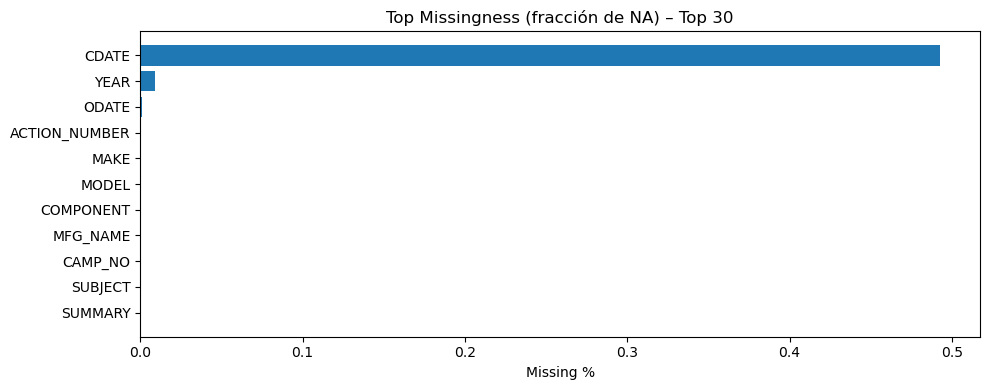

Duplicados de fila: 0
Sin columnas idénticas.
Columnas constantes: []
Columnas con >95% NA: []
Numéricos casi idénticos (|r|≥0.999): []


In [9]:

# Missingness
missing_count = df_std.isna().sum()
missing_pct = (missing_count / len(df_std)).astype(float)
missing_df = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct}).sort_values("missing_pct", ascending=False)
missing_df.to_csv(os.path.join(ARTIFACT_DIR, "missingness_summary.csv"))
display(missing_df.head(30))

# Barra top-30 missing
top_missing = missing_df.head(30)
plt.figure(figsize=(10, max(4, 0.35*len(top_missing))))
plt.barh(top_missing.index[::-1], top_missing["missing_pct"].iloc[::-1])
plt.title("Top Missingness (fracción de NA) – Top 30")
plt.xlabel("Missing %")
plt.tight_layout()
plt.show()

# Duplicados de fila
dup_rows = df_std.duplicated().sum()
print(f"Duplicados de fila: {dup_rows}")

# Columnas idénticas (hash + verificación)
from pandas.util import hash_pandas_object
hash_map = {}
for c in df_std.columns:
    try:
        h = hash_pandas_object(df_std[c], index=False).sum()
    except Exception:
        h = hash(tuple(df_std[c].astype(str).fillna('<NA>').tolist()))
    hash_map.setdefault(h, []).append(c)

ident_groups = []
for _, cols in hash_map.items():
    if len(cols) > 1:
        base = cols[0]
        eq = [base]
        for other in cols[1:]:
            if df_std[base].equals(df_std[other]):
                eq.append(other)
        if len(eq) > 1:
            ident_groups.append(eq)

if ident_groups:
    print("Grupos de columnas idénticas:")
    for g in ident_groups: print("  - " + ", ".join(g))
else:
    print("Sin columnas idénticas.")

# Constantes y alto-nulo
nunique_per_col = df_std.nunique(dropna=False)
constant_cols = [c for c in df_std.columns if nunique_per_col[c] <= 1]
high_null_cols = [c for c, pct in missing_pct.items() if pct > 0.95]
print(f"Columnas constantes: {constant_cols}")
print(f"Columnas con >95% NA: {high_null_cols}")

# Numéricas altamente correlacionadas (|r| >= 0.999)
num_cols = df_std.select_dtypes(include=['number', 'Float64', 'Int64']).columns.tolist()
high_corr_pairs = []
if len(num_cols) >= 2:
    corr_num = df_std[num_cols].corr(method='pearson').abs()
    for i, c1 in enumerate(num_cols):
        for j, c2 in enumerate(num_cols):
            if j <= i: continue
            v = corr_num.loc[c1, c2]
            if pd.notna(v) and v >= 0.999:
                high_corr_pairs.append((c1, c2, v))
print(f"Numéricos casi idénticos (|r|≥0.999): {high_corr_pairs}")


## 3) Categorical Analysis — cardinalidad, top niveles, entropía, plots

In [10]:

cat_like = [c for c in df_std.columns if (df_std[c].dtype == 'object') or pd.api.types.is_string_dtype(df_std[c]) or pd.api.types.is_bool_dtype(df_std[c])]
cat_reasonable = [c for c in cat_like if df_std[c].nunique(dropna=True) <= CAT_CARDINALITY_CAP]

rows = []
for c in cat_like:
    ser = df_std[c]
    nuniq = ser.nunique(dropna=True)
    uniq_r = ser.nunique(dropna=True) / len(df_std) if len(df_std) else 0.0
    ent = entropy_log2(ser.dropna())
    vc = ser.value_counts(dropna=True).head(10)
    top10 = "; ".join([f"{idx}:{cnt}" for idx, cnt in vc.items()])
    rows.append({"column": c, "nunique": int(nuniq), "unique_ratio": float(uniq_r), "entropy_log2": float(ent), "top10": top10})

cat_summary = pd.DataFrame(rows).sort_values(["nunique", "unique_ratio"], ascending=[True, False])
cat_summary.to_csv(os.path.join(ARTIFACT_DIR, "categorical_summary.csv"), index=False)
display(cat_summary.head(50))

# Plots (cap a 30 columnas y 20 niveles)
for c in cat_reasonable[:MAX_CATEGORICAL_PLOTS]:
    vc = df_std[c].value_counts(dropna=False).head(20)
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    plt.barh([str(x) for x in vc.index][::-1], vc.values[::-1])
    plt.title(f"{c} - Top niveles")
    plt.xlabel("Frecuencia")
    plt.tight_layout()
    plt.show()

very_high_card_cats = [c for c in cat_like if (df_std[c].nunique(dropna=True) / len(df_std) > 0.9)]
print(f"Categóricas de altísima cardinalidad (unique_ratio>0.9): {very_high_card_cats}")


,column,nunique,unique_ratio,entropy_log2,top10
3,COMPONENT,416,0.002710,5.161599,air bags:37845; air bags:frontal:37679; servic...
4,MFG_NAME,589,0.003837,4.586087,"chrysler (fca us, llc):20746; honda (american ..."
1,MAKE,666,0.004339,5.225723,honda:16552; dodge:13356; kia:12796; ford:1033...
7,SUMMARY,2660,0.017329,4.847184,the office of defects investigation (odi) open...
5,CAMP_NO,2790,0.018176,7.945191,nan:28098; 19v204000:1768; 18v934000:1768; 18v...
2,MODEL,3662,0.023857,8.388840,element:3678; soul:3616; accord:3019; sonata:2...
6,SUBJECT,3665,0.023876,4.845393,air bag inflator rupture:74305; non-crash vehi...
0,ACTION_NUMBER,5307,0.034573,5.426605,ea15001:71004; pe19004:7840; dp18003:7072; pe1...


Categóricas de altísima cardinalidad (unique_ratio>0.9): []


## 4) Numerical Analysis — stats, outliers, hist/box, series temporales

,column,count,mean,std,min,p25,p50,p75,max,outliers_iqr
0,YEAR,152143,2.370683e+03,1669.744284,1965.0,2003.0,2005.0,2011.0,9999.0,15768
1,CDATE,77876,2.010648e+07,111581.684381,19720530.0,20050506.0,20130815.0,20211209.0,20250919.0,930


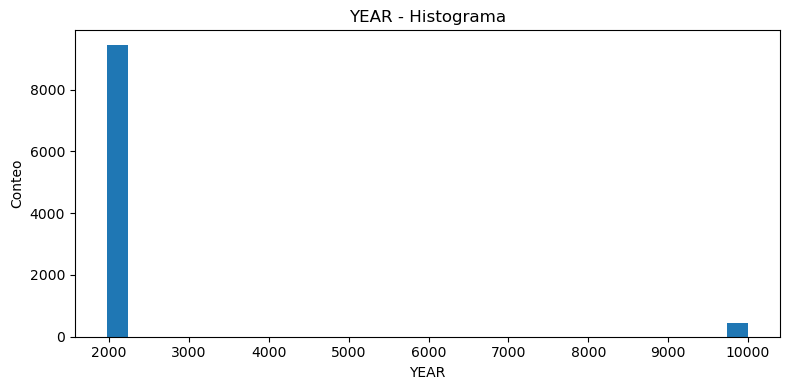

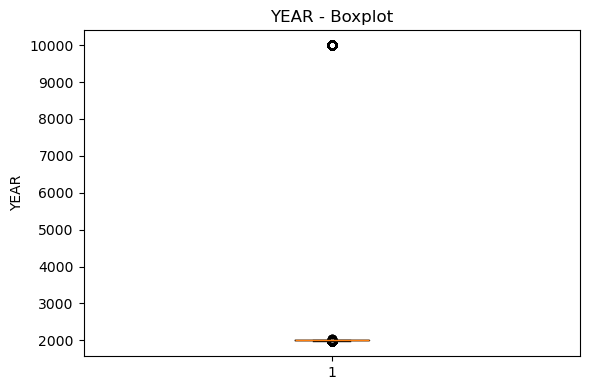

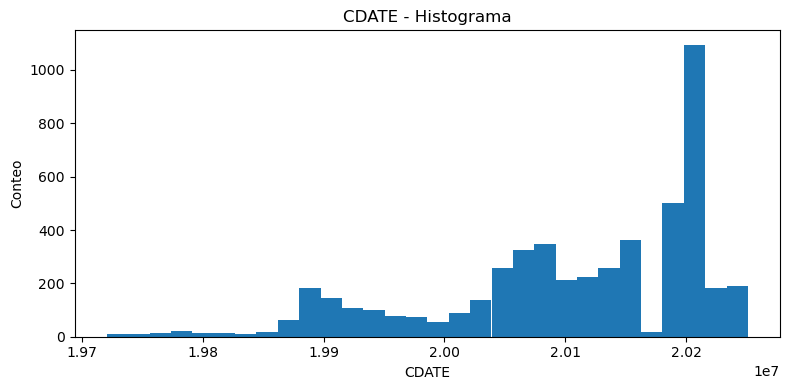

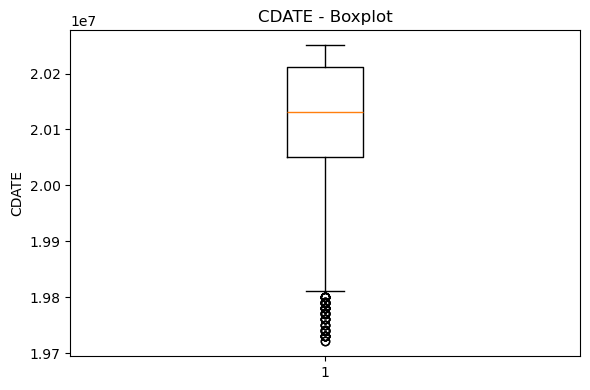

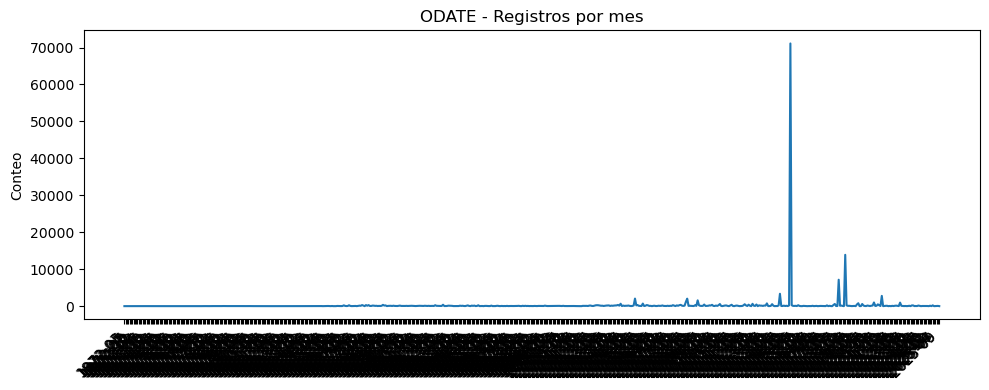

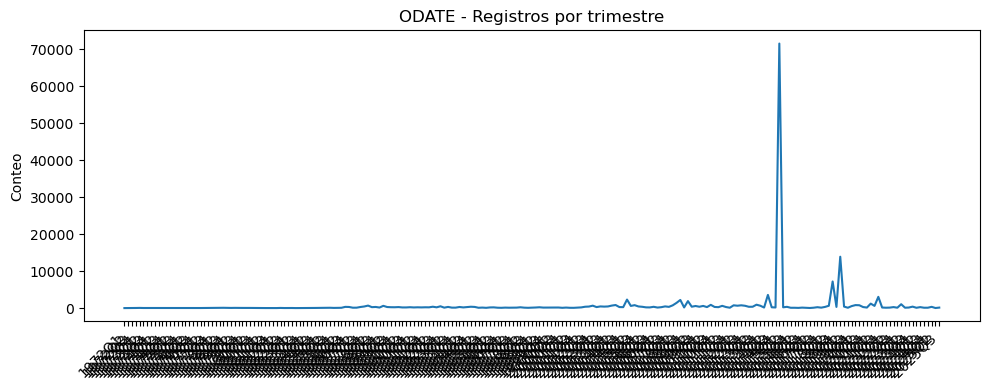

In [12]:

num_cols = df_std.select_dtypes(include=['number', 'Float64', 'Int64']).columns.tolist()
numeric_summary = []
for c in num_cols:
    s = pd.to_numeric(df_std[c], errors='coerce')
    desc = s.describe(percentiles=[0.25, 0.5, 0.75])
    Q1, Q3 = desc.get('25%', np.nan), desc.get('75%', np.nan)
    IQR = (Q3 - Q1) if (pd.notna(Q1) and pd.notna(Q3)) else np.nan
    if pd.notna(IQR):
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = int(((s < lower) | (s > upper)).sum())
    else:
        outliers = np.nan
    numeric_summary.append({
        "column": c,
        "count": int(desc.get("count", 0)) if not np.isnan(desc.get("count", np.nan)) else 0,
        "mean": float(desc.get("mean", np.nan)) if not np.isnan(desc.get("mean", np.nan)) else np.nan,
        "std": float(desc.get("std", np.nan)) if not np.isnan(desc.get("std", np.nan)) else np.nan,
        "min": float(desc.get("min", np.nan)) if not np.isnan(desc.get("min", np.nan)) else np.nan,
        "p25": float(Q1) if pd.notna(Q1) else np.nan,
        "p50": float(desc.get("50%", np.nan)) if not np.isnan(desc.get("50%", np.nan)) else np.nan,
        "p75": float(Q3) if pd.notna(Q3) else np.nan,
        "max": float(desc.get("max", np.nan)) if not np.isnan(desc.get("max", np.nan)) else np.nan,
        "outliers_iqr": outliers
    })
num_sum_df = pd.DataFrame(numeric_summary)
num_sum_df.to_csv(os.path.join(ARTIFACT_DIR, "numeric_summary.csv"), index=False)
display(num_sum_df)

# Muestreo para plots
df_plot = df_std.sample(n=min(len(df_std), MAX_ROWS_FOR_PLOTS), random_state=42) if len(df_std) > MAX_ROWS_FOR_PLOTS else df_std
for c in num_cols[:MAX_NUMERIC_PLOTS]:
    s = pd.to_numeric(df_plot[c], errors='coerce').dropna()
    if s.empty:
        continue
    plt.figure(figsize=(8, 4))
    plt.hist(s, bins=30)
    plt.title(f"{c} - Histograma")
    plt.xlabel(c) ; plt.ylabel("Conteo")
    plt.tight_layout() ; plt.show()

    plt.figure(figsize=(6, 4))
    plt.boxplot(s.values, vert=True, whis=1.5, showfliers=True)
    plt.title(f"{c} - Boxplot")
    plt.ylabel(c)
    plt.tight_layout() ; plt.show()

# Series en el tiempo (si hay columnas datetime)
date_cols = [c for c in df_std.columns if pd.api.types.is_datetime64_any_dtype(df_std[c])]
for c in date_cols[:3]:
    s = df_std[c].dropna()
    if s.empty: 
        continue
    by_month = s.dt.to_period("M").value_counts().sort_index()
    plt.figure(figsize=(10, 4))
    plt.plot(by_month.index.astype(str), by_month.values)
    plt.title(f"{c} - Registros por mes")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Conteo")
    plt.tight_layout() ; plt.show()

    by_quarter = s.dt.to_period("Q").value_counts().sort_index()
    plt.figure(figsize=(10, 4))
    plt.plot(by_quarter.index.astype(str), by_quarter.values)
    plt.title(f"{c} - Registros por trimestre")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Conteo")
    plt.tight_layout() ; plt.show()


## 5) Associations / Correlations — num↔num, cat↔cat (Cramér’s V), cat↔num (η)

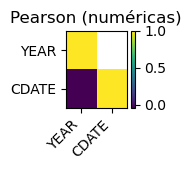

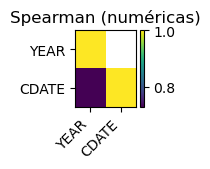

No hay suficientes categóricas razonables para Cramér’s V.


In [13]:

# Numéricas↔numéricas
pearson = pd.DataFrame()
spearman = pd.DataFrame()
num_cols = df_std.select_dtypes(include=['number', 'Float64', 'Int64']).columns.tolist()

if len(num_cols) >= 2:
    pearson = df_std[num_cols].corr(method='pearson')
    spearman = df_std[num_cols].corr(method='spearman')
    pearson.to_csv(os.path.join(ARTIFACT_DIR, "corr_numeric_pearson.csv"))
    spearman.to_csv(os.path.join(ARTIFACT_DIR, "corr_numeric_spearman.csv"))
    masked_heatmap(pearson, "Pearson (numéricas)")
    masked_heatmap(spearman, "Spearman (numéricas)")
    abs_p = pearson.abs()
    pairs = []
    for i, c1 in enumerate(num_cols):
        for j, c2 in enumerate(num_cols):
            if j <= i: continue
            v = abs_p.loc[c1, c2]
            if pd.notna(v) and v >= 0.8:
                pairs.append((c1, c2, float(pearson.loc[c1, c2])))
    if pairs:
        print("Pares fuertes |r|≥0.8 (Pearson):")
        for p in sorted(pairs, key=lambda x: -abs(x[2]))[:20]:
            print(f"  {p[0]} ~ {p[1]}: r={p[2]:.3f}")
else:
    print("No hay suficientes numéricas para correlaciones.")

# Categóricas↔categóricas (Cramér’s V)
cat_like = [c for c in df_std.columns if (df_std[c].dtype == 'object') or pd.api.types.is_bool_dtype(df_std[c])]
cat_for_assoc = [c for c in cat_like if df_std[c].nunique(dropna=True) <= CAT_CARDINALITY_CAP]
cat_for_assoc = sorted(cat_for_assoc, key=lambda c: df_std[c].nunique(dropna=True))[:TOP_CATEGORICAL_FOR_ASSOC]
cramers_matrix = pd.DataFrame(index=cat_for_assoc, columns=cat_for_assoc, dtype=float)

if len(cat_for_assoc) >= 2 and SCIPY_AVAILABLE:
    df_assoc = df_std[cat_for_assoc].sample(n=min(len(df_std), MAX_ROWS_FOR_PLOTS), random_state=42) if len(df_std) > MAX_ROWS_FOR_PLOTS else df_std[cat_for_assoc]
    for i, c1 in enumerate(cat_for_assoc):
        for j, c2 in enumerate(cat_for_assoc):
            if j > i:
                tbl = pd.crosstab(df_assoc[c1], df_assoc[c2])
                if tbl.size == 0:
                    val = np.nan
                else:
                    chi2, _, _, _ = chi2_contingency(tbl, correction=False)
                    n = tbl.values.sum()
                    phi2 = chi2 / max(n, 1)
                    r, k = tbl.shape
                    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1)) if n > 1 else 0
                    r_corr = r - ((r - 1)**2) / (n - 1) if n > 1 else r
                    k_corr = k - ((k - 1)**2) / (n - 1) if n > 1 else k
                    denom = min((k_corr - 1), (r_corr - 1))
                    val = math.sqrt(phi2_corr / denom) if denom > 0 else np.nan
                cramers_matrix.loc[c1, c2] = val
                cramers_matrix.loc[c2, c1] = val
            elif j == i:
                cramers_matrix.loc[c1, c2] = 1.0
    cramers_matrix.to_csv(os.path.join(ARTIFACT_DIR, "cramers_v.csv"))
    masked_heatmap(cramers_matrix, "Cramér’s V (cat↔cat)")
    pairs = []
    for i, c1 in enumerate(cat_for_assoc):
        for j, c2 in enumerate(cat_for_assoc):
            if j <= i: continue
            v = cramers_matrix.loc[c1, c2]
            if pd.notna(v) and v >= 0.5:
                pairs.append((c1, c2, float(v)))
    if pairs:
        print("Asociaciones categóricas fuertes (V ≥ 0.5):")
        for p in sorted(pairs, key=lambda x: -x[2])[:20]:
            print(f"  {p[0]} ~ {p[1]}: V={p[2]:.3f}")
else:
    if not SCIPY_AVAILABLE:
        print("SciPy no disponible; se omite Cramér’s V.")
    else:
        print("No hay suficientes categóricas razonables para Cramér’s V.")

# Categórica↔numérica (η)
eta_rows = []
num_cols = df_std.select_dtypes(include=['number', 'Float64', 'Int64']).columns.tolist()
if len(num_cols) >= 1 and len(cat_for_assoc) >= 1:
    df_cn = df_std[cat_for_assoc + num_cols].sample(n=min(len(df_std), MAX_ROWS_FOR_PLOTS), random_state=42) if len(df_std) > MAX_ROWS_FOR_PLOTS else df_std[cat_for_assoc + num_cols]
    for c_cat in cat_for_assoc:
        for c_num in num_cols:
            s = pd.DataFrame({"cat": df_cn[c_cat], "val": pd.to_numeric(df_cn[c_num], errors='coerce')}).dropna()
            if s.empty:
                eta = np.nan
            else:
                groups = s.groupby("cat")["val"]
                mean_total = s["val"].mean()
                ss_between = sum(g.size * (g.mean() - mean_total) ** 2 for _, g in groups)
                ss_total = ((s["val"] - mean_total) ** 2).sum()
                eta = float(ss_between / ss_total) if ss_total != 0 else 0.0
            eta_rows.append({"categorical": c_cat, "numeric": c_num, "eta": eta})
eta_df = pd.DataFrame(eta_rows)
if not eta_df.empty:
    eta_pivot = eta_df.pivot_table(index="categorical", columns="numeric", values="eta")
    eta_pivot.to_csv(os.path.join(ARTIFACT_DIR, "correlation_ratio.csv"))
    strong_eta = eta_df[eta_df["eta"] >= 0.3].sort_values("eta", ascending=False).head(20)
    if not strong_eta.empty:
        print("Categórica→numérica fuertes (η ≥ 0.3):")
        for _, r in strong_eta.iterrows():
            print(f"  {r['categorical']} → {r['numeric']}: η={r['eta']:.3f}")


## 6) KG-oriented Relationship Hints — llaves, m→1, co-ocurrencias, texto

In [14]:

# Llaves candidatas
candidate_keys = [c for c in df_std.columns 
                  if (df_std[c].nunique(dropna=True) / len(df_std) >= 0.98) 
                  and (df_std[c].nunique(dropna=False) > 1)
                  and (df_std[c].isna().mean() <= 0.95)]
print(f"Llaves candidatas (unique_ratio ≥ 0.98): {candidate_keys}")

# Llaves compuestas (2 columnas) entre id-like o alta-únicidad
highuniq_or_id = [c for c in df_std.columns if is_id_like(c) or (df_std[c].nunique(dropna=True)/len(df_std) >= 0.9)][:10]
combo_candidates = []
for c1, c2 in itertools.combinations(highuniq_or_id, 2):
    ur = (df_std[[c1, c2]].drop_duplicates().shape[0]) / len(df_std) if len(df_std) else 0
    if ur >= 0.98:
        combo_candidates.append((c1, c2, ur))
if combo_candidates:
    print("Llaves compuestas (2-col) con unique_ratio ≥ 0.98:")
    for c1, c2, ur in combo_candidates:
        print(f"  {c1} + {c2} → unique_ratio={ur:.3f}")

# Patrones muchos-a-uno
many_to_one_hints = []
attrs = [c for c in df_std.columns if c not in candidate_keys]
for key in candidate_keys[:10]:
    g = df_std.groupby(key)
    for a in attrs:
        nun_by_key = g[a].nunique(dropna=True)
        if len(nun_by_key) == 0: 
            continue
        frac_const = (nun_by_key <= 1).mean()
        if pd.notna(frac_const) and frac_const >= 0.95:
            many_to_one_hints.append({"key": key, "attribute": a, "frac_constant_across_keys": float(frac_const)})
if many_to_one_hints:
    print("Patrones m→1 (atributo constante en ≥95% de llaves):")
    for r in many_to_one_hints[:20]:
        print(f"  {r['key']} → {r['attribute']} ({r['frac_constant_across_keys']:.0%})")

# Co-ocurrencias para dos categóricas pequeñas (<=20 niveles)
cat_small = [c for c in df_std.columns if (df_std[c].dtype == 'object') and (df_std[c].nunique(dropna=True) <= 20)]
if len(cat_small) >= 2:
    c1, c2 = cat_small[0], cat_small[1]
    top1 = df_std[c1].value_counts().head(20).index
    top2 = df_std[c2].value_counts().head(20).index
    sub = df_std[df_std[c1].isin(top1) & df_std[c2].isin(top2)]
    cm = pd.crosstab(sub[c1], sub[c2])
    plt.figure(figsize=(min(12, 2 + 0.5*cm.shape[1]), min(10, 2 + 0.5*cm.shape[0])))
    plt.imshow(cm.values, aspect='auto', interpolation='nearest')
    plt.title(f"Co-ocurrencia: {c1} x {c2}")
    plt.xticks(range(cm.shape[1]), cm.columns.astype(str), rotation=45, ha='right')
    plt.yticks(range(cm.shape[0]), cm.index.astype(str))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Texto: estadísticos de longitud
text_cols = [c for c in df_std.columns if df_std[c].dtype == 'object']
txt_rows = []
for c in text_cols:
    lens = df_std[c].dropna().astype(str).str.len()
    non_empty_pct = (df_std[c].notna() & (df_std[c].astype(str).str.len() > 0)).mean()
    txt_rows.append({
        "column": c,
        "pct_non_empty": float(non_empty_pct),
        "mean_len": float(lens.mean()) if not lens.empty else 0.0,
        "median_len": float(lens.median()) if not lens.empty else 0.0,
        "p95_len": float(lens.quantile(0.95)) if not lens.empty else 0.0
    })
text_len_df = pd.DataFrame(txt_rows).sort_values("pct_non_empty", ascending=False)
display(text_len_df.head(50))


Llaves candidatas (unique_ratio ≥ 0.98): []


,column,pct_non_empty,mean_len,median_len,p95_len
0,ACTION_NUMBER,1.0,6.998899,7.0,7.0
1,MAKE,1.0,5.699950,5.0,10.0
2,MODEL,1.0,6.781259,6.0,14.0
3,COMPONENT,1.0,23.332239,16.0,57.0
4,MFG_NAME,1.0,22.661663,22.0,32.0
5,CAMP_NO,1.0,6.481639,6.0,9.0
6,SUBJECT,1.0,25.241998,24.0,36.0
7,SUMMARY,1.0,2396.033485,3176.0,3546.0
